<a href="https://colab.research.google.com/github/Lama-Aldhafeeri/CAMelBERT/blob/main/Training_UBC_NLP_MARBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

In [ ]:
!pip install torch

In [ ]:

!pip install transformers camel-tools scikit-learn datasets matplotlib

  Using cached camel_tools-1.5.5-py3-none-any.whl.metadata (10 kB)
  Using cached docopt-0.6.2.tar.gz (25 kB)
  Preparing metadata (setup.py) ... done
  Using cached transformers-4.43.4-py3-none-any.whl.metadata (43 kB)
  Using cached pyrsistent-0.20.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (27 kB)
  Using cached muddler-0.1.3-py3-none-any.whl.metadata (7.5 kB)
  Using cached camel-kenlm-2024.5.6.zip (556 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.5/124.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 64.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 10.9 MB/s eta 0:00:00
  Created wheel for camel-kenlm: filename=camel_kenlm-2024.5.6-cp310-cp310-linux_x86_64.whl size=3184602 sha

In [ ]:
pip install transformers datasets arabert torch scikit-learn matplotlib seaborn


In [ ]:
pip install --upgrade transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 86.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 102.0 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.43.4
    Uninstalling transformers-4.43.4:
      Successfully uninstalled transformers-4.43.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
camel-tools 1.5.5 requires transformers<4.44.0,>=4.0, but you have transformers 4.46.2 which is incompatible.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/56662 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.141400,0.209068,0.926233,0.926827,0.926360,0.927560


Evaluation on the test set:


Test Accuracy: 0.9262
Classification Report on Test Set:
              precision    recall  f1-score   support

         Neg       0.94      0.91      0.93      4085
        Neut       0.89      0.90      0.90      3764
         Pos       0.94      0.96      0.95      3484

    accuracy                           0.93     11333
   macro avg       0.93      0.93      0.93     11333
weighted avg       0.93      0.93      0.93     11333



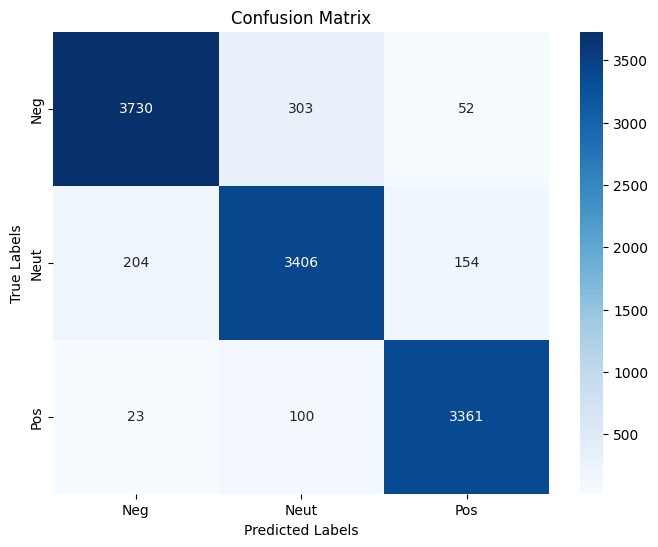

In [ ]:
from google.colab import drive
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from datasets import Dataset
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import EarlyStoppingCallback
from arabert.preprocess import ArabertPreprocessor
import pandas as pd

import os
os.environ["WANDB_MODE"] = "disabled"


# Load the dataset
dataset_url = 'https://raw.githubusercontent.com/Lama-Aldhafeeri/CAMelBERT/refs/heads/main/three_labeld_data_with_headers.csv'
df_original = pd.read_csv(dataset_url)
df_original = df_original.reset_index(drop=True)

# Preprocess the Arabic text using AraBERT's preprocessing pipeline
model_name = 'UBC-NLP/MARBERT'
arabert_prep = ArabertPreprocessor(model_name=model_name)
df_original['Post'] = df_original['Post'].apply(arabert_prep.preprocess)

# Convert DataFrame to Dataset
dataset = Dataset.from_pandas(df_original[['Post', 'Polarity']])

# Load tokenizer and model for AraBERT
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# Ensure all model tensors are contiguous
def make_model_tensors_contiguous(model):
    for param in model.parameters():
        param.data = param.data.contiguous()

make_model_tensors_contiguous(model)

# Tokenize and preprocess the dataset
def preprocess_data(examples):
    # Tokenize the text
    tokenized_data = tokenizer(examples['Post'], padding='max_length', truncation=True, max_length=128)

    # Apply label mapping to the 'Polarity' column
    tokenized_data['labels'] = [ {'Neg': 0, 'Neut': 1, 'Pos': 2}[label] for label in examples['Polarity'] ]

    return tokenized_data


# Apply the preprocessing function to the dataset
tokenized_dataset = dataset.map(preprocess_data, batched=True)

# Split dataset into train and test
split_dataset = tokenized_dataset.train_test_split(test_size=0.2)


# Set up training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,
    save_total_limit=2
)

# Define evaluation metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=split_dataset['train'],
    eval_dataset=split_dataset['test'],
    compute_metrics=compute_metrics,
)

# Fine-tune the model
trainer.train()

# Evaluate the model on the test set
print("Evaluation on the test set:")
evaluation_results = trainer.evaluate()

# Additional testing code for manual evaluation
test_results = trainer.predict(split_dataset['test'])

# Extract predictions and true labels
predictions = torch.argmax(torch.tensor(test_results.predictions), axis=1)
true_labels = test_results.label_ids

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f"Test Accuracy: {accuracy:.4f}")

# Generate classification report
label_mapping = {'Neg': 0, 'Neut': 1, 'Pos': 2}
print("Classification Report on Test Set:")
print(classification_report(true_labels, predictions, target_names=list(label_mapping.keys())))

# Generate confusion matrix and plot it
cm = confusion_matrix(true_labels, predictions)

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(cm, labels=list(label_mapping.keys()))